In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/gl*obal/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

# Functions, data loading

In [2]:
# Monthly data
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81

gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")

topo_hires = xr.open_dataset("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)

monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


In [3]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)


for MR in MRs:
    print(MR.name)
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Z',orogm)
    MR.set_2dvar('Z_HR',np.maximum(topo_hires,0.))
    MR.set_3dvar('T',"128_130_t")
    MR.set_3dvar('Q',"128_133_q")
    MR.set_3dvar('U',"128_131_u")
    MR.set_3dvar('V',"128_132_v")
    MR.set_uperp()
    

ghats
myanmar
vietnam
malaysia
philippines
newbritain


# Fig - Pr maps

In [7]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
def tilted_rect_distance(grid,x1,y1,x2,y2,distups1,distups2,reverse=False):
    x = grid.longitude
    y = grid.latitude
    scalarprod_para = (x-x1)*(y2-y1) - (x2-x1)*(y-y1)
    scalarprod_perp_up = (x-x1)*(x2-x1)+(y-y1)*(y2-y1)
    scalarprod_perp_dn = (x-x2)*(x1-x2)+(y-y2)*(y1-y2)
    if reverse:
        halfplane_para = scalarprod_para <=0
    else:
        halfplane_para = scalarprod_para >=0
    halfplane_perp_up = scalarprod_perp_up >= 0
    halfplane_perp_dn = scalarprod_perp_dn >= 0
    distance_across = np.sqrt((x-x1)**2+(y-y1)**2 - scalarprod_perp_up**2/((x2-x1)**2+(y2-y1)**2))*np.sign(scalarprod_para)
    return (halfplane_perp_up*halfplane_perp_dn*(distance_across<distups1)*(distance_across>distups2)).transpose('latitude','longitude')

def inbox(grid,box):
    x = grid.longitude
    y = grid.latitude
    return (x>box[0]+0.1)*(x<box[1]-0.1)*(y>box[2]+0.1)*(y<box[3]-0.1)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


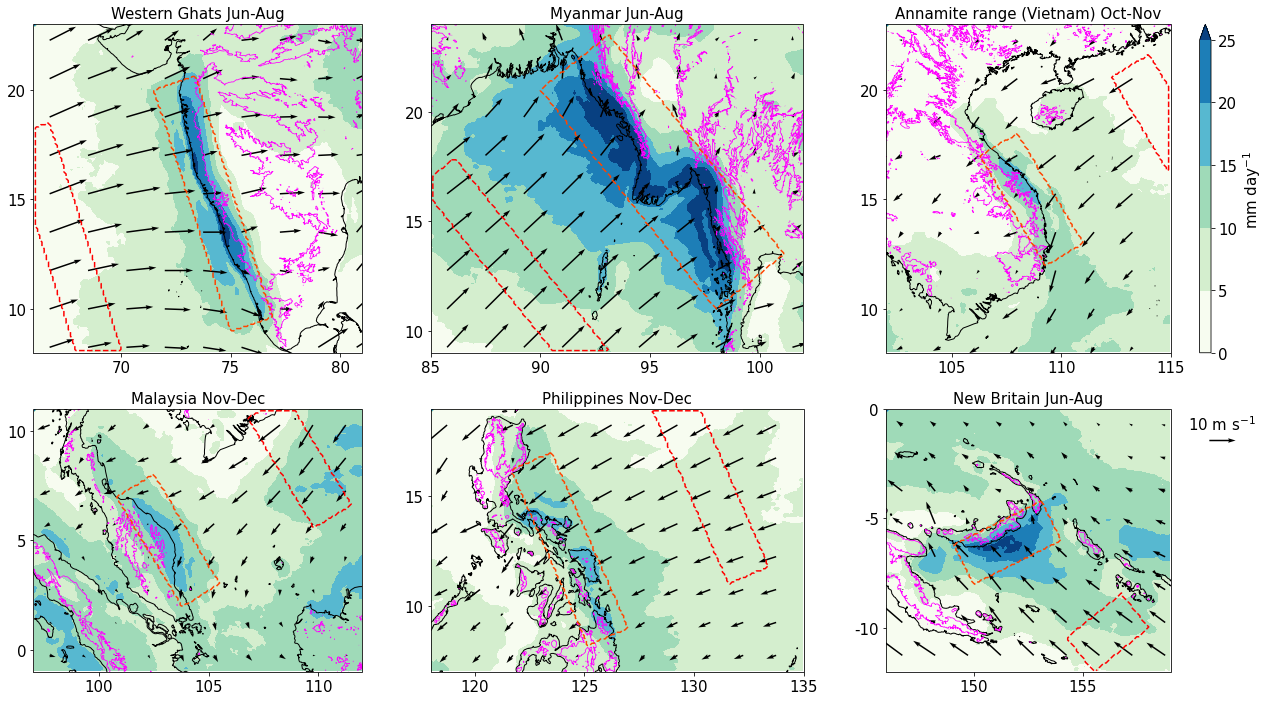

In [12]:
fig = plt.figure(figsize=(18,10))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [15,17,15],height_ratios=[1.25,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax.set_anchor('W')
    ax.coastlines()
    
    box=MR.box_plot
    pr=sel_months(sel_box(gpm_pr_seasmean,box),MR.months).mean('month')
    pr[0,0]=26.
    c = pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)#,cbar_kwargs={'shrink':0.8,'label':'mm/day'})
    cs.append(c)
    sel_box(topo_hires,box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.75],colors=['magenta'])
    tilted_rect(pr,*MR.box_tilted_plot).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['orangered'])
    if i<5:
        (tilted_rect_distance(pr,*MR.box_tilted_plot[:-1],-5,-7)*inbox(pr,box)).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['red'])
    else:
         tilted_rect(pr,*MR.box_tilted_plot_ups).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['red'])

                   
    u=sel_months(sel_box(era5100u_seasmean,box),MR.months).mean('month')
    v=sel_months(sel_box(era5100v_seasmean,box),MR.months).mean('month')
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(MR.Lname +' '+ monthnames[MR.months[0]-1] +'-'+ monthnames[MR.months[-1]-1],fontsize=15)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$')

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

# Quiver key (reference wind arrow)
qk = axs[5].quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')
fig.tight_layout()
#fig.suptitle("GPM-IMERG pr & 10m wind composited over rainy season for each region",fontsize=20);None

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


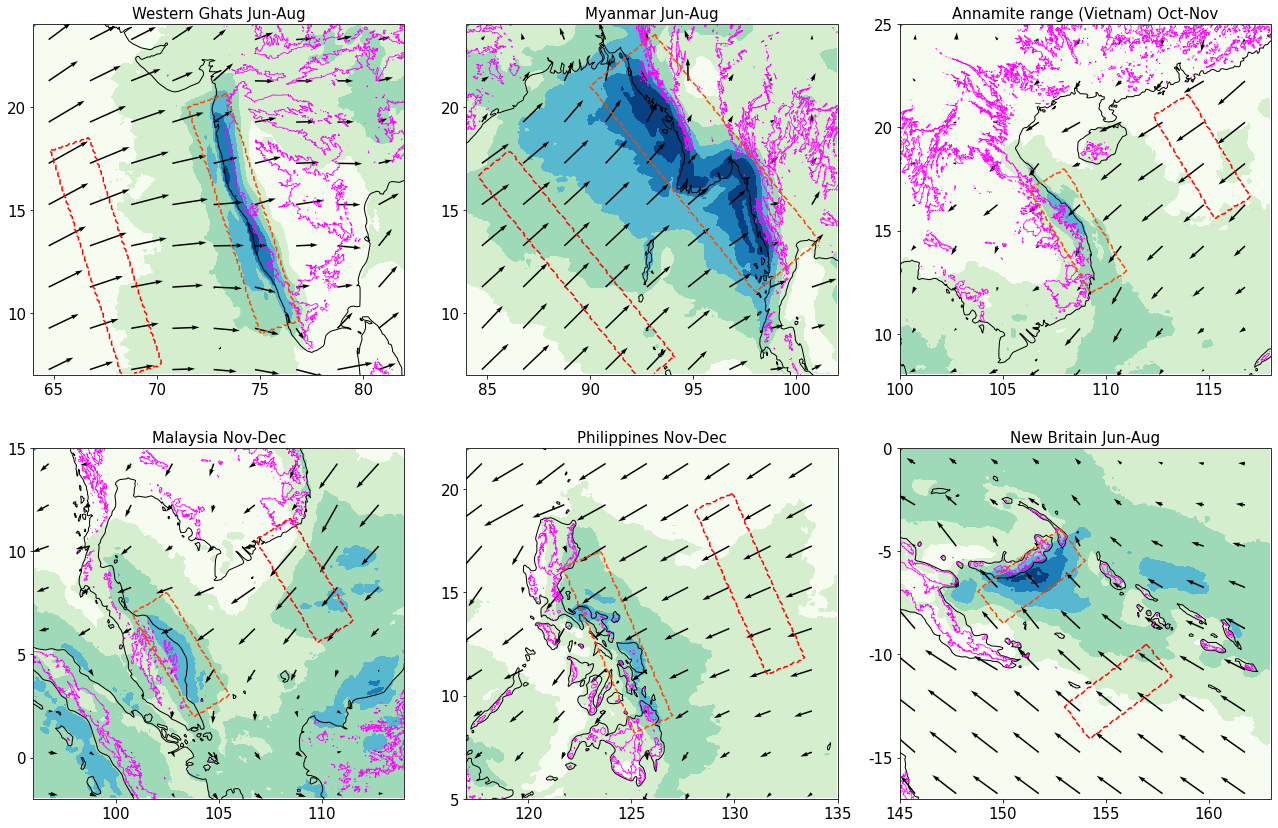

In [9]:
fig,axs = plt.subplots(2,3,figsize=(18,12),subplot_kw={'projection':ccrs.PlateCarree()})
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    ax=axs[i]
    ax.set_anchor('W')
    ax.coastlines()
    
    box=MR.box
    pr=sel_months(sel_box(gpm_pr_seasmean,box),MR.months).mean('month')
    pr[0,0]=26.
    pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

    sel_box(topo_hires,box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.75],colors=['magenta'])
    tilted_rect(pr,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['orangered'])
    tilted_rect_distance(pr,*MR.box_tilted[:-1],-5,-7).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['red'])
  
    u=sel_months(sel_box(era5100u_seasmean,box),MR.months).mean('month')
    v=sel_months(sel_box(era5100v_seasmean,box),MR.months).mean('month')
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    
    
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(MR.Lname +' '+ monthnames[MR.months[0]-1] +'-'+ monthnames[MR.months[-1]-1],fontsize=15)

fig.tight_layout()
#fig.suptitle("GPM-IMERG pr & 10m wind composited over rainy season for each region",fontsize=20);None

# Fig - precip vs BL spatial maps

In [4]:
for MR in MRs:
    MR.set_daily_Blsimple_vars()


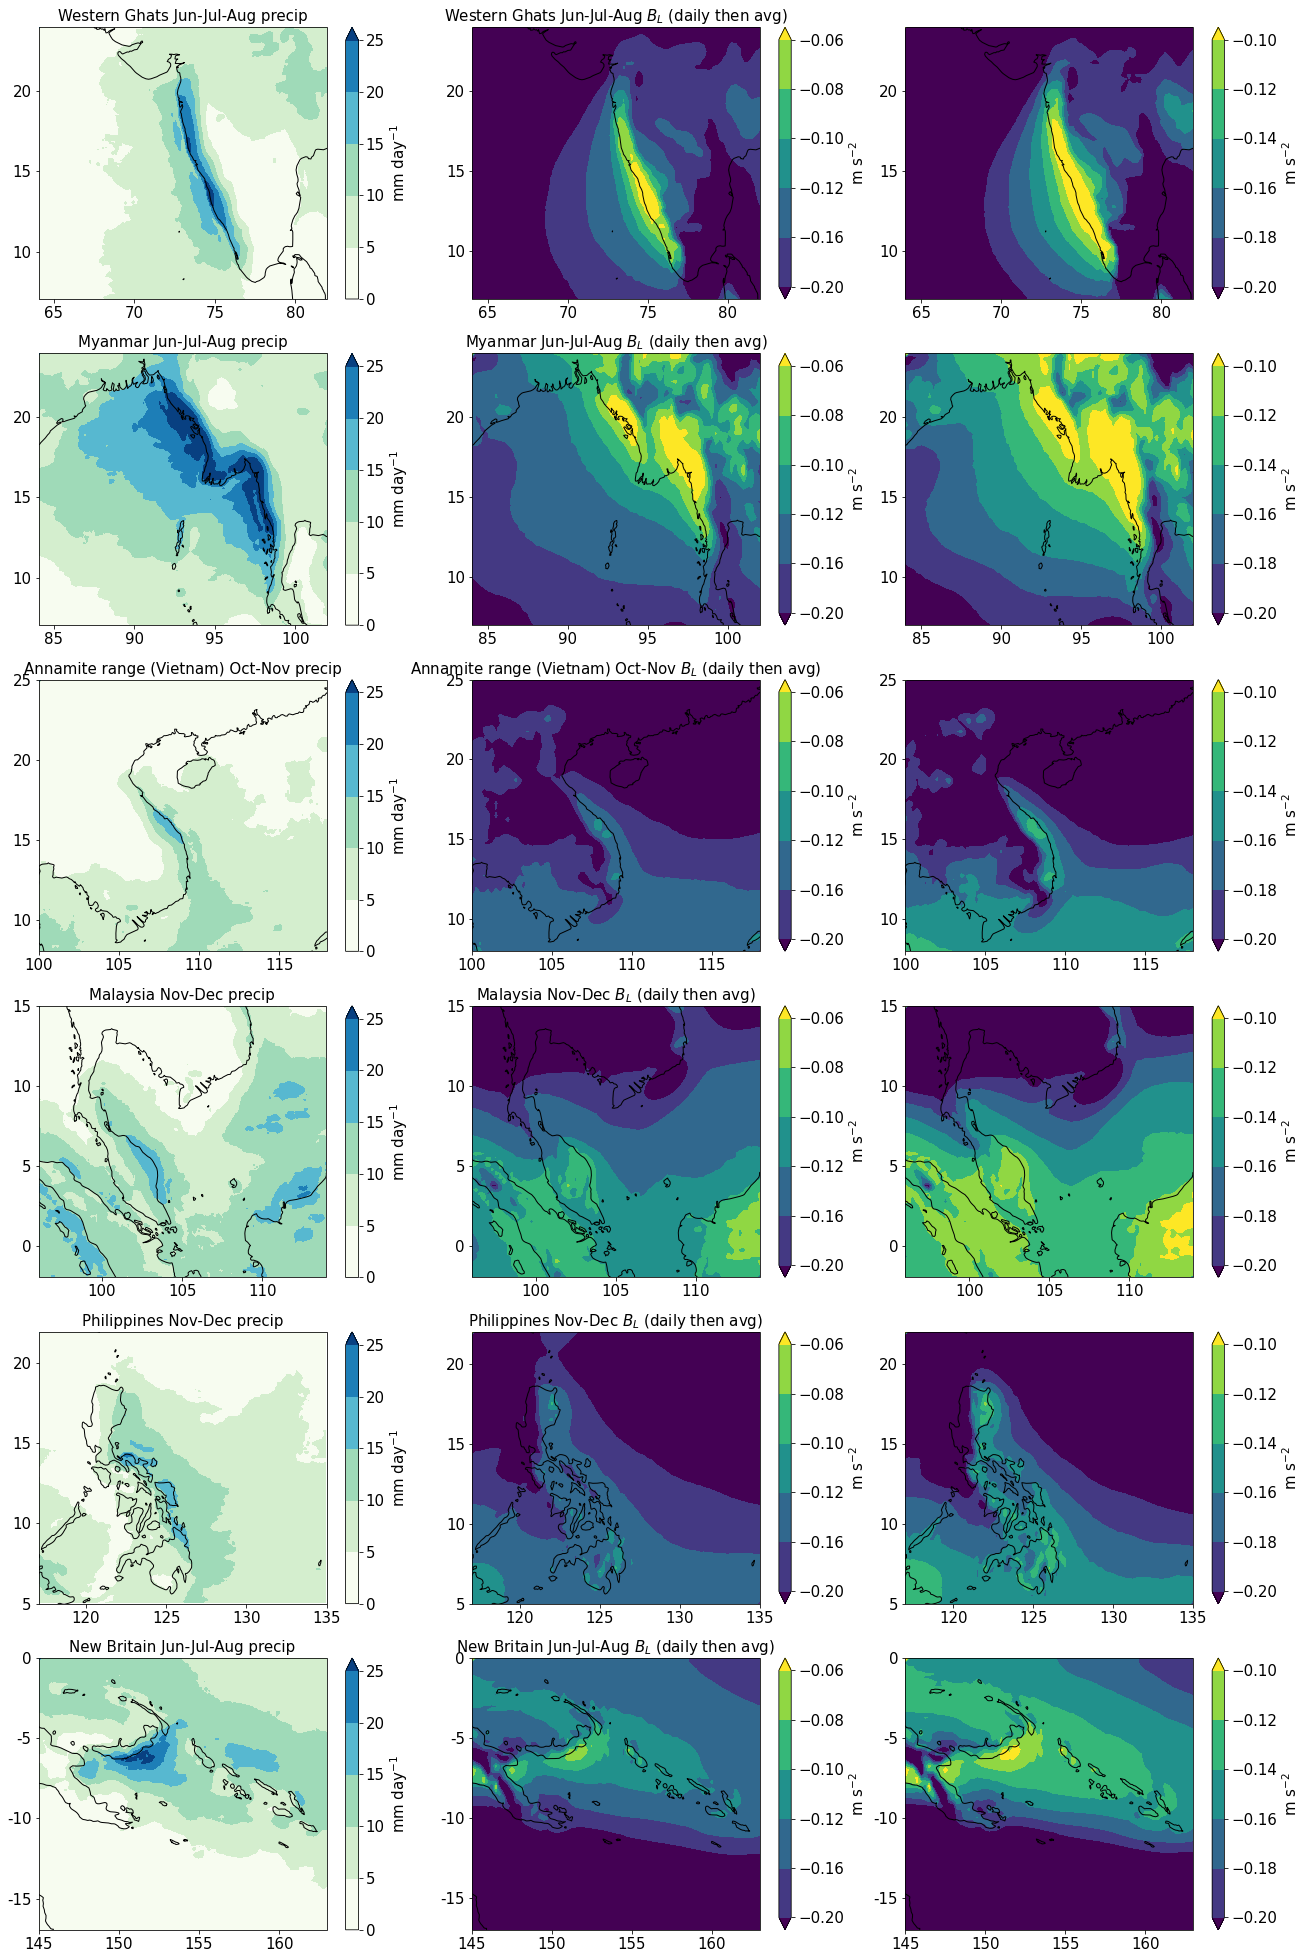

In [11]:
fig,axss = plt.subplots(6,3,figsize=(22,35),subplot_kw={'projection': ccrs.PlateCarree()})
for i,MR in enumerate(MRs):
    axs = axss[i]
    
    ax=axs[0]
    box=MR.box
    pr=MR.vars['GPM_PR']
    pr[0,0]=26.
    pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,cbar_kwargs = {'label':r'mm day$^{-1}$'})
      
    ax=axs[1]
    BL = BL_plevs_vectorized(MR.vars['T'],MR.vars['Q'],700.,900.)
    BL[0,0]=0.
    BL[-1,-1]=-0.21
    BL.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=[-0.2,-0.16,-0.12,-0.1,-0.08,-0.06],cmap=plt.cm.viridis,cbar_kwargs = {'label':r'm s$^{-2}$'})

    ax=axs[2]
    BL = MR.vars['BLSIMPLE_DAILY'].mean('time')
    BL[0,0]=0.
    BL[-1,-1]=-0.21
    BL.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(-0.2,-0.1,6),cmap=plt.cm.viridis,cbar_kwargs = {'label':r'm s$^{-2}$'})
    
    
    for ax in axs:
        ax.set_anchor('W')
        ax.coastlines()
        dl=5
        lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
        ax.set_xticks(lons)
        ax.set_xticklabels(lons)
        lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
        ax.set_yticks(lats)
        ax.set_yticklabels(lats)
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    axs[0].set_title(MR.Lname +' '+ '-'.join(monthnames[m-1] for m in MR.months) + ' precip',fontsize=15)
    axs[1].set_title(MR.Lname +' '+ '-'.join(monthnames[m-1] for m in MR.months) + r' $B_L$',fontsize=15)
    axs[1].set_title(MR.Lname +' '+ '-'.join(monthnames[m-1] for m in MR.months) + r' $B_L$ (daily then avg)',fontsize=15)


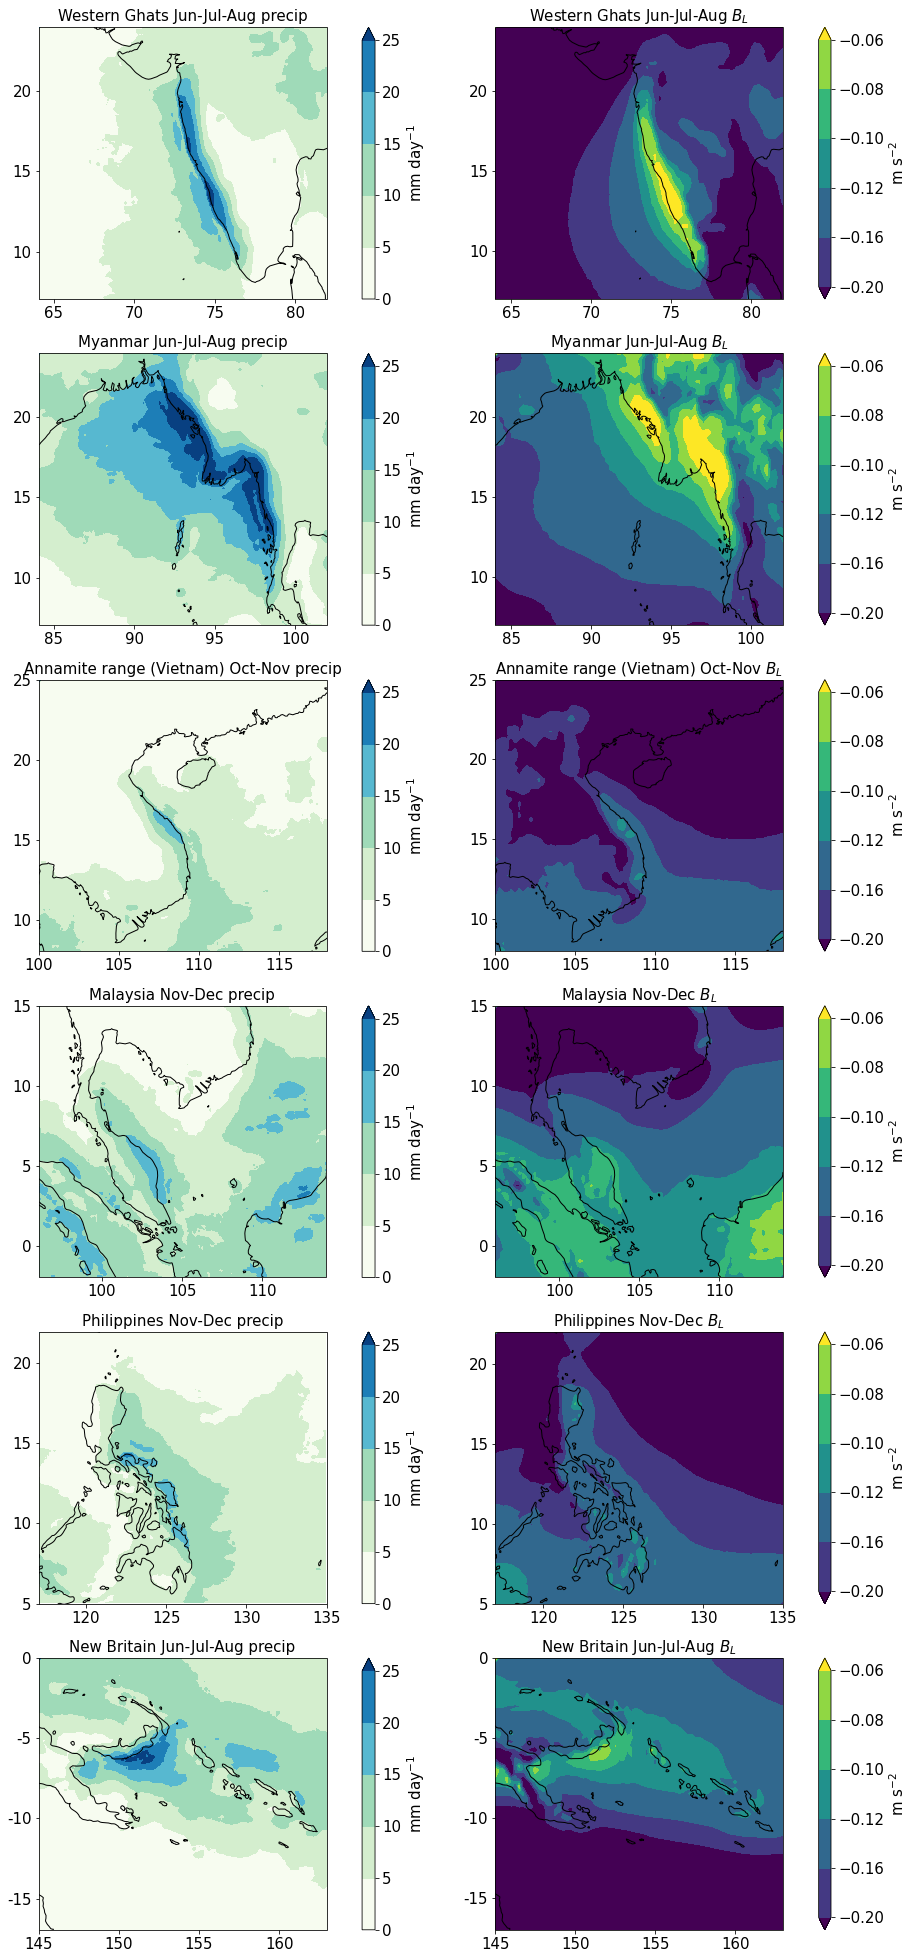

In [5]:
fig,axss = plt.subplots(6,2,figsize=(15,35),subplot_kw={'projection': ccrs.PlateCarree()})
for i,MR in enumerate(MRs):
    axs = axss[i]
    
    ax=axs[0]
    box=MR.box
    pr=MR.vars['GPM_PR']
    pr[0,0]=26.
    pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,cbar_kwargs = {'label':r'mm day$^{-1}$'})
      
    ax=axs[1]
    BL = BL_plevs_vectorized(MR.vars['T'],MR.vars['Q'],700.,900.)
    BL[0,0]=0.
    BL[-1,-1]=-0.21
    BL.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=[-0.2,-0.16,-0.12,-0.1,-0.08,-0.06],cmap=plt.cm.viridis,cbar_kwargs = {'label':r'm s$^{-2}$'})
    
    for ax in axs:
        ax.set_anchor('W')
        ax.coastlines()
        dl=5
        lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
        ax.set_xticks(lons)
        ax.set_xticklabels(lons)
        lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
        ax.set_yticks(lats)
        ax.set_yticklabels(lats)
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    axs[0].set_title(MR.Lname +' '+ '-'.join(monthnames[m-1] for m in MR.months) + ' precip',fontsize=15)
    axs[1].set_title(MR.Lname +' '+ '-'.join(monthnames[m-1] for m in MR.months) + r' $B_L$',fontsize=15)


In [32]:
Ghats      .angle = 80 ; Ghats      .width = 0.25; Ghats      .P0 = 2
Myanmar    .angle = 50 ; Myanmar    .width = 0.25; Myanmar    .P0 = 7
Vietnam    .angle = 240; Vietnam    .width = 0.15; Vietnam    .P0 = 3
Malaysia   .angle = 240; Malaysia   .width = 0.15; Malaysia   .P0 = 10
Philippines.angle = 250; Philippines.width = 0.25; Philippines.P0 = 5
Newbritain .angle = 310; Newbritain .width = 0.15; Newbritain .P0 = 4

In [33]:
def rot_slice(var,angle,width):
    rvar = rotate_var(var.transpose('latitude','longitude'),angle)
    n,m = rvar.shape
    bounds = int(m*(0.5-width)), int(m*(0.5+width))
    return rvar.isel(y=slice(*bounds)).mean('y')

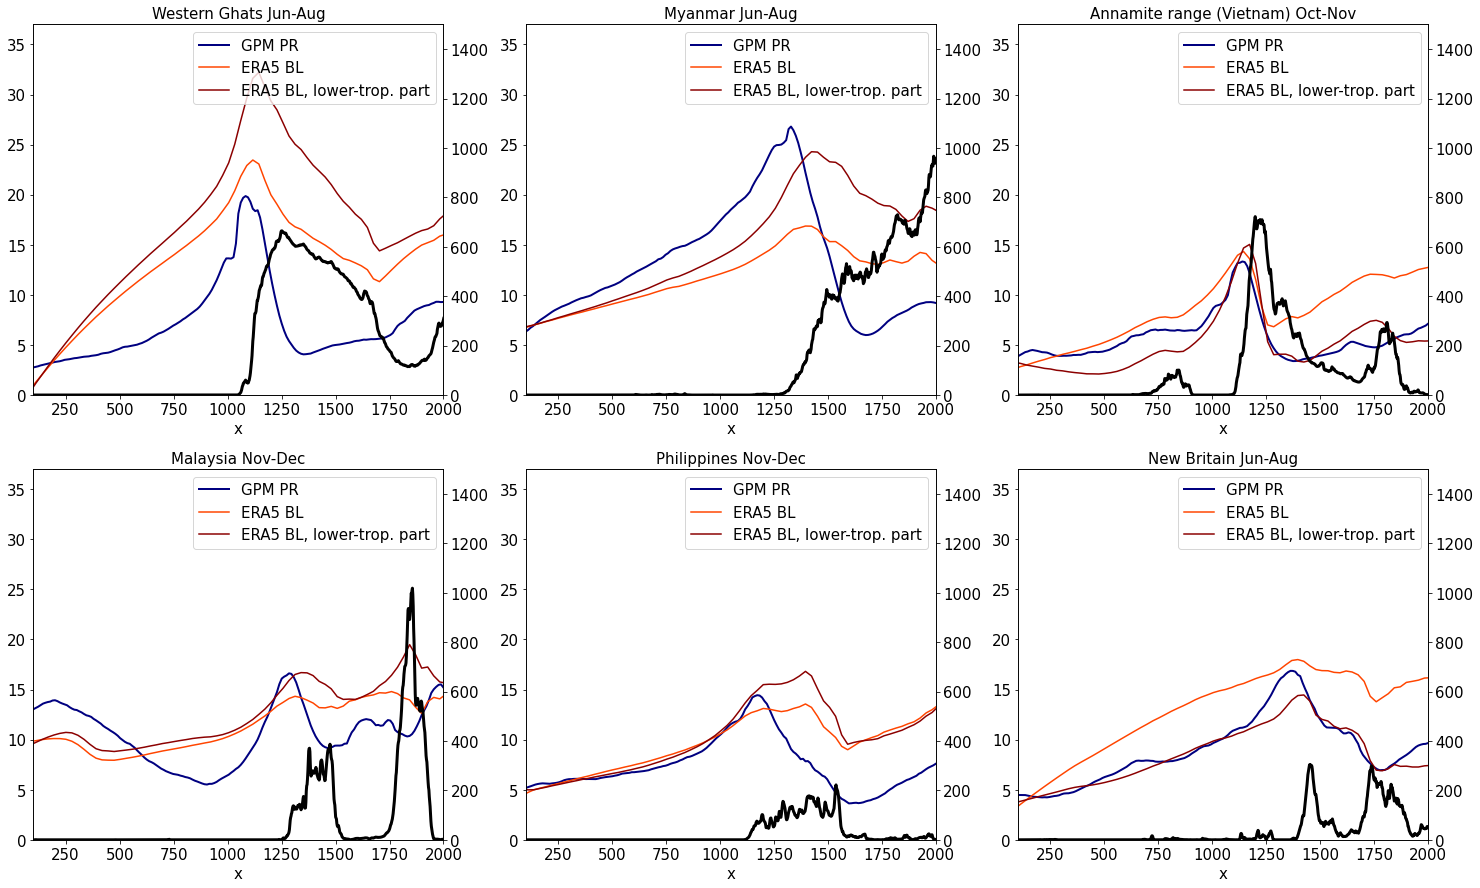

In [37]:
fig,axs = plt.subplots(2,3,figsize=(25,15))
axs=axs.reshape(-1)

for ax,MR in zip(axs,MRs):
    ### FIRST ###
    pr=MR.vars['GPM_PR']
    rot_slice(pr,MR.angle,MR.width).plot(ax=ax,color='navy',linewidth=2,label='GPM PR')
    
    ### SECOND ###
    BL = MR.vars['BLSIMPLE_DAILY'].mean('time')
    BL = rot_slice(BL,MR.angle,MR.width)
    (MR.P0+5*20*(BL-BL[5])).plot(ax=ax,color='orangered',label='ERA5 BL')
    
    #BL = BL_plevs_vectorized(MR.vars['T'],MR.vars['Q'],700.,900.)
    #BL = rot_slice(BL,MR.angle,MR.width)
    #(MR.P0+5*20*(BL-BL[0])).plot(ax=ax,color='r')
    
    ### THIRD ###
    T = rot_slice(MR.vars['T'].sel(level=slice(700,900)).mean('level'),MR.angle,MR.width)
    Q = rot_slice(MR.vars['Q'].sel(level=slice(700,900)).mean('level'),MR.angle,MR.width)
    (MR.P0+(-(T-T[5])*1004/(3600*7.5)+(Q-Q[5])*2.5e6/(3600*27.5))*8000/2.5e6*86400).plot(ax=ax,color='darkred',label='ERA5 BL, lower-trop. part')
    
    ax2 = ax.twinx()
    rot_slice(MR.vars['Z_HR'],MR.angle,MR.width).plot(ax=ax2,color='k',linewidth=3)
        
    ax.set_ylim(0,37)
    ax2.set_ylim(0,1500)
    ax.set_xlim(100,2000)
    ax.set_title(MR.Lname +' '+monthnames[MR.months[0]-1]+'-'+monthnames[MR.months[-1]-1],fontsize=15)
    ax.legend()

# Fig - T cross sections

In [19]:
climcapst_climatology = xr.open_zarr("/global/cscratch1/sd/qnicolas/CLIMCAPS_V2/monthly/L3_CLIMCAPS_QCC.air_temp.monthly.zarr").air_temp.groupby('time.month').mean(['time','orbit_pass'])
Ghats.set_othervar('CLIMCAPS_T',sel_box_month(climcapst_climatology,Ghats.box,Ghats.pr_month).assign_coords(level=climcapst_climatology.air_pres/100).swap_dims({'air_pres':'level'}))


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [35]:
import itertools
windyevent=['20060701','20060706']

era5t_ghats_jjahourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_130_t.ll025sc.%i%s.ghats.zarr"%(year,month)) for year,month in itertools.product(range(2001,2016),('06','07','08'))),dim='time').T
climcapst_ghats_jjadaily = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/L3_CLIMCAPS_QCC.air_temp.2002-2015.%s.ghats.zarr"%month).air_temp for month in ('06','07','08')),dim="time").sortby('time')
climcapst_ghats_jjadaily = climcapst_ghats_jjadaily.assign_coords(level=climcapst_ghats_jjadaily.air_pres/100).swap_dims({'air_pres':'level'})


era5t_event = era5t_ghats_jjahourly.sel(time=slice(windyevent[0],windyevent[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
era5tprime_event = era5t_event-era5t_event.sel(longitude=slice(68,70)).mean('longitude')

airst_event = climcapst_ghats_jjadaily.sel(time=slice(windyevent[0],windyevent[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
airstprime_event=airst_event-airst_event.sel(longitude=slice(68,70)).mean('longitude')
    

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [37]:
era5t_mean = Ghats.vars['T'].sel(latitude=slice(15,13)).mean('latitude')
era5tprime_mean = era5t_mean-era5t_mean.sel(longitude=slice(68,70)).mean('longitude')

airst_mean = Ghats.vars['CLIMCAPS_T'].sel(latitude=slice(15,13)).mean('latitude')
airstprime_mean = airst_mean-airst_mean.sel(longitude=slice(68,70)).mean('longitude')


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


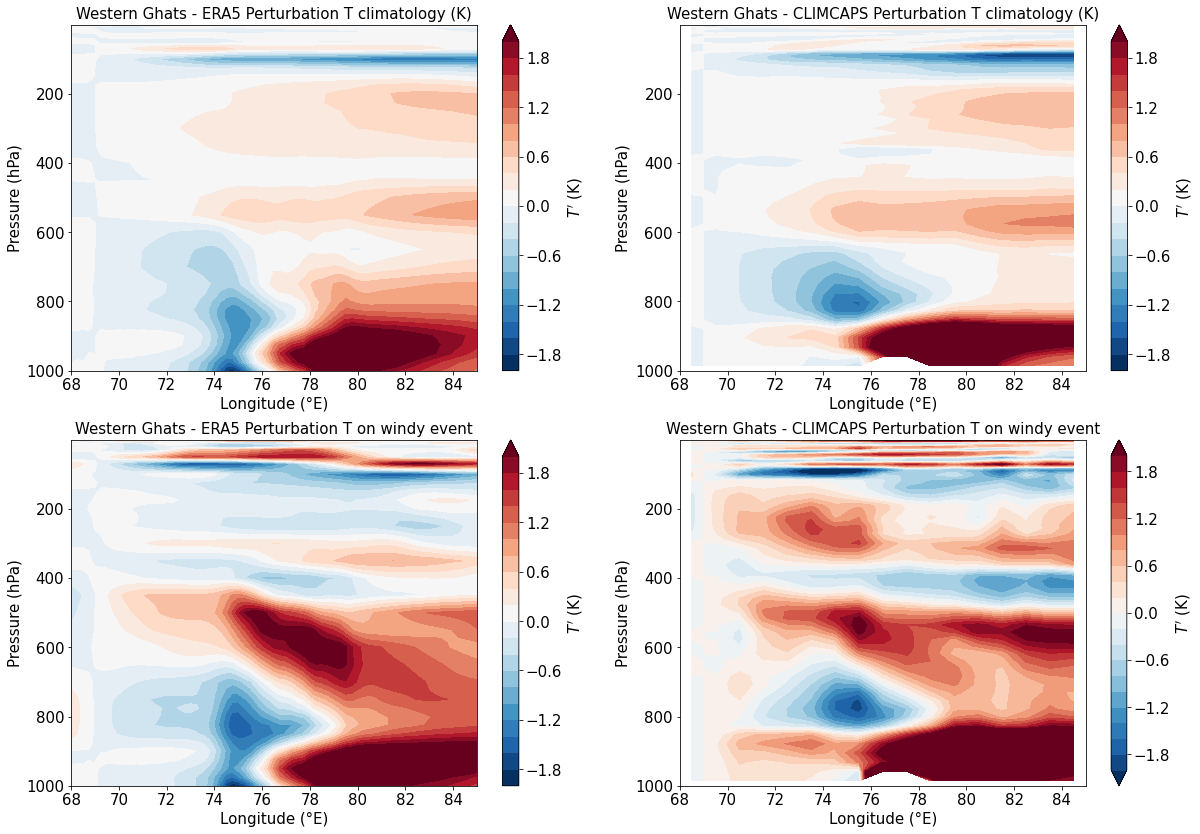

In [40]:

fig,axs = plt.subplots(2,2,figsize=(20,14))
axs=axs.reshape(-1)
lvls = np.arange(-2,2.1,0.2)
#plot_xz(axs[0],Ghats,'T',pert=True,levels=lvls,cbar_kwargs = {'label':r"$T'$ (K)"})
#plot_xz(axs[1],Ghats,'CLIMCAPS_T',pert=True,levels=lvls,cbar_kwargs = {'label':r"$T'$ (K)"})
era5tprime_mean.plot.contourf(ax=axs[0],y='level',yincrease=False,levels=lvls,cmap=plt.cm.RdBu_r,cbar_kwargs = {'label':r"$T'$ (K)"})
airstprime_mean.plot.contourf(ax=axs[1],y='level',yincrease=False,levels=lvls,cmap=plt.cm.RdBu_r,cbar_kwargs = {'label':r"$T'$ (K)"})

axs[0].set_title(r'Western Ghats - ERA5 Perturbation T climatology (K)',fontsize=15)
axs[1].set_title(r'Western Ghats - CLIMCAPS Perturbation T climatology (K)',fontsize=15)

#airs T
airstprime_event.plot.contourf(ax=axs[3],y='level',yincrease=False,levels=lvls,cmap=plt.cm.RdBu_r,cbar_kwargs = {'label':r"$T'$ (K)"})
#ERA5 T
era5tprime_event.plot.contourf(ax=axs[2],y='level',yincrease=False,levels=lvls,cmap=plt.cm.RdBu_r,cbar_kwargs = {'label':r"$T'$ (K)"})


axs[2].set_title(r'Western Ghats - ERA5 Perturbation T on windy event',fontsize=15)
axs[3].set_title(r'Western Ghats - CLIMCAPS Perturbation T on windy event',fontsize=15)

for ax in axs:
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Pressure (hPa)")
    ax.set_ylim(1000,1)
    ax.set_xlim(68,85)


# Seasonal cycle plots